In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
cars = r"C:\Users\hp\Documents\maskRCNN\car"
bus = r"C:\Users\hp\Documents\maskRCNN\bus"
ambulance = r"C:\Users\hp\Documents\maskRCNN\ambulance"
motorcycle = r"C:\Users\hp\Documents\maskRCNN\motorcycle"
truck = r"C:\Users\hp\Documents\maskRCNN\truck"

In [3]:
car_images = []
car_labels = []
for image_file in os.listdir(cars):
    images1 = cv2.imread(os.path.join(cars, image_file),cv2.IMREAD_GRAYSCALE)
    images1 = cv2.resize(images1, (64, 64))  # Resize the image to 64x64 pixels
    images1 = images1.astype('float32') / 255.0
    car_images.append(images1)
    car_labels.append(1)  # Assign label 1 for car class

In [4]:
bus_images = []
bus_labels = []
for image_file in os.listdir(bus):
    images2 = cv2.imread(os.path.join(bus, image_file),cv2.IMREAD_GRAYSCALE)
    images2 = cv2.resize(images2, (64, 64))  # Resize the image to 64x64 pixels
    images2 = images2.astype('float32') / 255.0
    bus_images.append(images2)
    bus_labels.append(2)  # Assign label 2 for bus class

In [5]:
amb_images = []
amb_labels = []
for image_file in os.listdir(ambulance):
    images3 = cv2.imread(os.path.join(ambulance, image_file),cv2.IMREAD_GRAYSCALE)
    images3 = cv2.resize(images3, (64, 64))  # Resize the image to 64x64 pixels
    images3 = images3.astype('float32') / 255.0
    amb_images.append(images3)
    amb_labels.append(3)  # Assign label 3 for vehicle class

In [6]:
motor_images = []
motor_labels = []
for image_file in os.listdir(motorcycle):
    images4 = cv2.imread(os.path.join(motorcycle, image_file),cv2.IMREAD_GRAYSCALE)
    images4 = cv2.resize(images1, (64, 64))  # Resize the image to 64x64 pixels
    images4 = images4.astype('float32') / 255.0
    motor_images.append(images4)
    motor_labels.append(4)  # Assign label 1 for vehicle class

In [7]:
truck_images = []
truck_labels = []
for image_file in os.listdir(truck):
    images5 = cv2.imread(os.path.join(truck, image_file),cv2.IMREAD_GRAYSCALE)
    images5 = cv2.resize(images1, (64, 64))  # Resize the image to 64x64 pixels
    images5 = images5.astype('float32') / 255.0
    truck_images.append(images5)
    truck_labels.append(5)  # Assign label 1 for vehicle class

In [8]:
# Concatenate images and labels
all_images = car_images + bus_images + truck_images +amb_images + motor_images
all_labels = car_labels + bus_labels + truck_labels + amb_labels + motor_labels

# Split the dataset into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

In [9]:
print(images1.shape)

(64, 64)


In [10]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [11]:
train_images = train_images.reshape(len(train_images),64,64,1)
test_images = test_images.reshape(len(test_images),64,64,1)

In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
def build_model(hp):  
    model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(64,64,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [14]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [15]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

C:\Users\hp\AppData\Local\Temp\ipykernel_7944\556418634.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [16]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="vehicle")

In [17]:
tuner_search.search(train_images,train_labels,epochs=9,validation_split=0.1)

Trial 5 Complete [00h 00m 54s]
val_accuracy: 0.6000000238418579

Best val_accuracy So Far: 0.6000000238418579
Total elapsed time: 00h 02m 57s
INFO:tensorflow:Oracle triggered exit


In [18]:
model = tuner_search.get_best_models(num_models=1)[0]

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 48)        1248      
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        27712     
                                                                 
 flatten (Flatten)           (None, 215296)            0         
                                                                 
 dense (Dense)               (None, 112)               24113264  
                                                                 
 dense_1 (Dense)             (None, 10)                1130      
                                                                 
Total params: 24,143,354
Trainable params: 24,143,354
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(train_images, train_labels, epochs=20, validation_split=0.1,initial_epoch=3)

Epoch 4/20
3/3 [==============================] - 4s 943ms/step - loss: 0.9294 - accuracy: 0.6782 - val_loss: 0.9640 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 2s 817ms/step - loss: 0.5996 - accuracy: 0.7816 - val_loss: 0.9846 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 3s 884ms/step - loss: 0.4265 - accuracy: 0.8391 - val_loss: 1.4203 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 3s 845ms/step - loss: 0.3054 - accuracy: 0.8391 - val_loss: 1.2385 - val_accuracy: 0.6000
Epoch 8/20
3/3 [==============================] - 3s 852ms/step - loss: 0.2566 - accuracy: 0.9195 - val_loss: 1.3168 - val_accuracy: 0.5000
Epoch 9/20
3/3 [==============================] - 3s 833ms/step - loss: 0.1950 - accuracy: 0.8966 - val_loss: 1.7326 - val_accuracy: 0.5000
Epoch 10/20
3/3 [==============================] - 3s 848ms/step - loss: 0.1786 - accuracy: 0.8966 - val_loss: 2.1472 - val_accuracy: 0.6000
Epoch 11/20
3/3 [==

In [21]:
val_loss, val_acc = model.evaluate(train_images,train_labels)
print("Loss value is ", val_loss)
print("Accuracy value is ", val_acc)

4/4 [==============================] - 0s 78ms/step - loss: 0.4367 - accuracy: 0.8866
Loss value is  0.43668049573898315
Accuracy value is  0.8865979313850403


In [22]:
prediction = model.predict([test_images])
print(prediction)

1/1 [==============================] - 0s 213ms/step
[[1.43006911e-25 9.99760568e-01 2.24852585e-04 1.44812147e-05
  1.55767109e-16 3.15582308e-18 4.63624542e-17 1.86228900e-18
  1.19618061e-18 1.02212547e-18]
 [2.99493479e-22 9.99704659e-01 6.12456643e-05 2.34037565e-04
  8.67902798e-12 1.44931796e-13 6.66913559e-14 9.98427910e-16
  7.00164952e-16 2.32574876e-15]
 [6.84007000e-06 4.27419180e-03 3.59951693e-04 9.03435342e-04
  5.99730790e-01 3.93413216e-01 4.56182810e-04 2.11175993e-05
  4.56833623e-05 7.88528530e-04]
 [2.25615677e-20 9.99151587e-01 5.36477950e-04 3.11901094e-04
  1.53218454e-12 5.77925498e-14 1.87761455e-13 1.40147192e-14
  7.35731463e-15 9.30658647e-15]
 [4.88554087e-18 9.46427822e-01 3.66545618e-02 1.69176105e-02
  7.96800889e-11 8.68471180e-12 1.63133298e-12 5.18700317e-13
  2.37067392e-13 4.76500295e-13]
 [6.84007000e-06 4.27419180e-03 3.59951693e-04 9.03435342e-04
  5.99730790e-01 3.93413216e-01 4.56182810e-04 2.11175993e-05
  4.56833623e-05 7.88528530e-04]
 [1.8

In [27]:
import numpy as np
print(np.argmax(prediction[1])) 

1


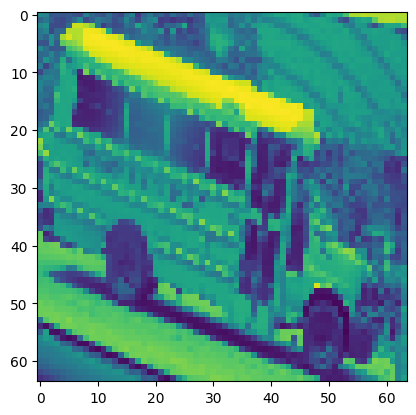

In [28]:
import matplotlib.pyplot as plt
plt.imshow(test_images[1])
plt.show()